In [ ]:

import pandas as pd
from data_fetch import *
from datetime import date, timedelta
import numpy as np


TICKERS = ["SBER", "VTBR", "SIBN",          "LKOH",   "ROSN"]
NAME    = ["Сбер", "ВТБ",  "Газпром Нефть", "Лукойл", "Роснефть"]

# Вычисляем вчерашнюю дату
yesterday = date.today() - timedelta(days=1)
YEST = yesterday.isoformat()

# Цена закрытия для каждой акции с 1 января 2020 года до вчерашнего дня
close_series = {
    t: api_request(t, "2020-01-01", YEST)["close"]
    for t in TICKERS
}
prices = pd.concat(close_series, axis = 1)
prices.columns.name = "Ticker"
prices.index.name   = "Date"



## Выводим цену акций в момент закрытия торгов во вчерашний день

In [2]:

display(prices.loc[[YEST]])


Ticker,SBER,VTBR,SIBN,LKOH,ROSN
Date,,,,,
2025-05-29,306.65,94.17,520.85,6680.5,424.95


## Посмотрим как менялись акции СБЕРА и ВТБ  за последние 5 лет

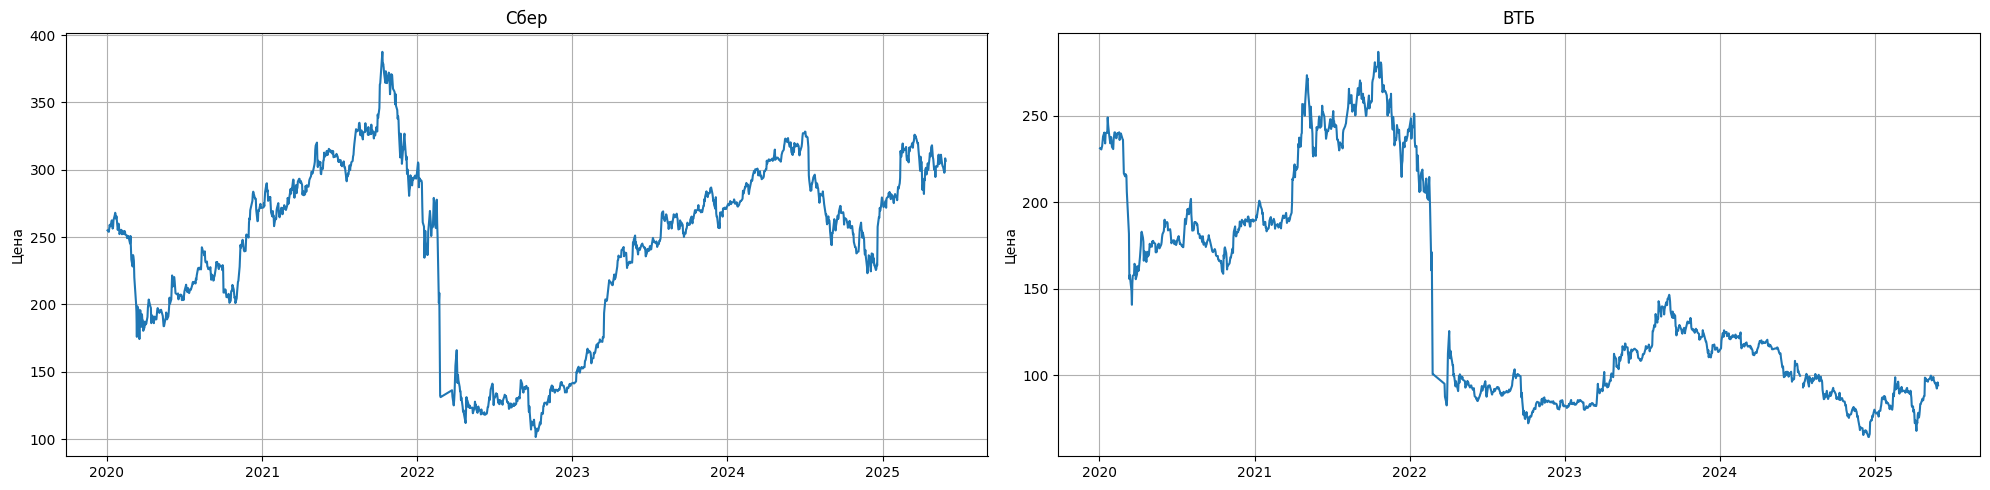

In [3]:
import math
import matplotlib.pyplot as plt


n = len(TICKERS[:2])
cols = 2
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows), sharex=True)
axes = axes.flatten()

for ax, ticker, name in zip(axes, TICKERS[:2], NAME[:2]):
    ax.plot(prices.index, prices[ticker])
    ax.set_title(name)
    ax.set_ylabel("Цена")
    ax.grid(True)


plt.tight_layout()
plt.show()


## Посмотрим на Газпром Нефть, Лукойл и Роснефть

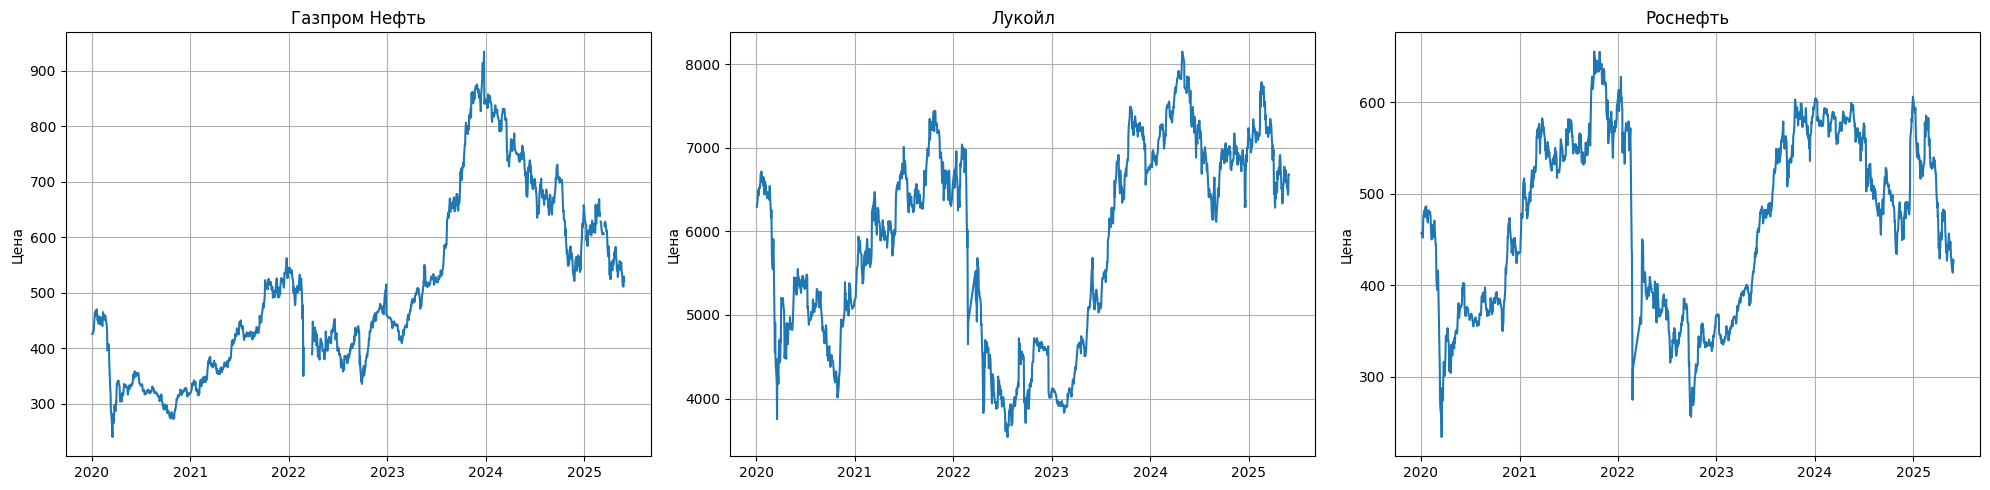

In [4]:
n = len(TICKERS[2:])
cols = 3
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows), sharex=True)
axes = axes.flatten()

for ax, ticker, name in zip(axes, TICKERS[2:], NAME[2:]):
    ax.plot(prices.index, prices[ticker])
    ax.set_title(name)
    ax.set_ylabel("Цена")
    ax.grid(True)


plt.tight_layout()
plt.show()

## Посмотрим теперь на покатели этих акций, возьмём такие параметры:
### EPS — прибыль на акцию за последний отчётный год (Чистая прибыль / Кол-во акций)
### BVPS — балансовая стоимость на акцию             (Собственный капитал / Кол-во акций)
### DIV  — последняя фактическая дивидендная выплата

Для SBER: [EPS](https://smart-lab.ru/q/SBER/MSFO/eps/), [Собственный капитал](https://ru.investing.com/pro/MISX:SBER/explorer/roe), [Диведенды](https://bcs.ru/markets/sber/tqbr/dividends?utm_referrer=https%3a%2f%2fwww.google.com%2f)  
Для VTBR (ВТБ): [EPS](https://smart-lab.ru/q/VTBR/MSFO/eps/), [Собственный капитал](https://ru.investing.com/pro/MISX:VTBR/explorer/roe), [Диведенды](https://bcs.ru/markets/vtbr/tqbr/dividends)  
Для SIBN (Газпром Нефть): [EPS](https://smart-lab.ru/q/SIBN/MSFO/eps/), [Собственный капитал](https://ru.investing.com/pro/MISX:SIBN/explorer/roe), [Диведенды](https://bcs.ru/markets/sibn/tqbr/dividends)  
Для LKOH (Лукойл): [EPS](https://smart-lab.ru/q/LKOH/MSFO/eps/), [Собственный капитал](https://ru.investing.com/pro/MISX:LKOH/explorer/roe), [Диведенды](https://bcs.ru/markets/lkoh/tqbr/dividends)  
Для ROSN (Роснефть) : [EPS](https://smart-lab.ru/q/ROSN/MSFO/eps/), [Собственный капитал](https://ru.investing.com/pro/MISX:ROSN/explorer/roe), [Диведенды](https://bcs.ru/markets/rosn/tqbr/dividends) 


In [ ]:

Params = {
    "SBER": {"EPS": 75.00,  "Equity": 6_878, "DIV": 34.84},
    "VTBR": {"EPS": 103.10,  "Equity": 1_861, "DIV": 25.58},
    "SIBN": {"EPS": 87.00, "Equity": 3_008, "DIV": 27.21},
    "LKOH": {"EPS": 1252.00, "Equity": 6_605, "DIV": 541.00},
    "ROSN": {"EPS": 102.30, "Equity": 8_785, "DIV": 14.68},
}


for t, p in Params.items():
    equity_rub = p["Equity"] * 1_000_000_000 
    shares     = get_number(t)               
    p["BVPS"]  = equity_rub / shares         

df_params = pd.DataFrame.from_dict(Params, orient="index")[["EPS", "BVPS", "DIV"]]
df_params.index.name = "Ticker"
display(df_params)


,EPS,BVPS,DIV
Ticker,,,
SBER,75.0,318.618454,34.84
VTBR,103.1,346.559201,25.58
SIBN,87.0,634.425206,27.21
LKOH,1252.0,9532.871102,541.00
ROSN,72.3,828.916079,14.68


Далее, по полученным данным посчитаем

### Цена по Грэма — справедливая цена по формуле Б. Грэма (√(22.5 × EPS × BVPS))  
### Коэфициент Грэма — отношение рынка к «справедливой» цене (Текущая цена акции / Graham Price)
### P/E — коэффициент «цена/прибыль» (Текущая цена акции / EPS)
### P/B — коэффициент «цена/балансовая стоимость» (Текущая цена акции / BVPS)
### DY — дивидендная доходность в процентах

In [19]:
last_prices = prices.iloc[-1]

rows = []
for t in Params:
    p   = last_prices[t]
    eps = Params[t]["EPS"]
    bv  = Params[t]["BVPS"]
    div = Params[t]["DIV"]

    gp  = np.sqrt(22.5 * eps * bv)
    rows.append(dict(
        Ticker=t, Price=p, EPS=eps, BVPS=bv,
        GrahamPrice=gp,
        GrahamRatio=p / gp,
        P_E=p / eps,
        P_B=p / bv,
        DY=div / p * 100
    ))

valuation = (pd.DataFrame(rows)
               .set_index("Ticker")
               .round(2)
               .sort_values("GrahamRatio"))
display(valuation)

,Price,EPS,BVPS,GrahamPrice,GrahamRatio,P_E,P_B,DY
Ticker,,,,,,,,
VTBR,94.17,103.1,346.56,896.62,0.11,0.91,0.27,27.16
ROSN,424.95,72.3,828.92,1161.22,0.37,5.88,0.51,3.45
LKOH,6680.50,1252.0,9532.87,16387.22,0.41,5.34,0.70,8.10
SBER,306.65,75.0,318.62,733.26,0.42,4.09,0.96,11.36
SIBN,520.85,87.0,634.43,1114.40,0.47,5.99,0.82,5.22


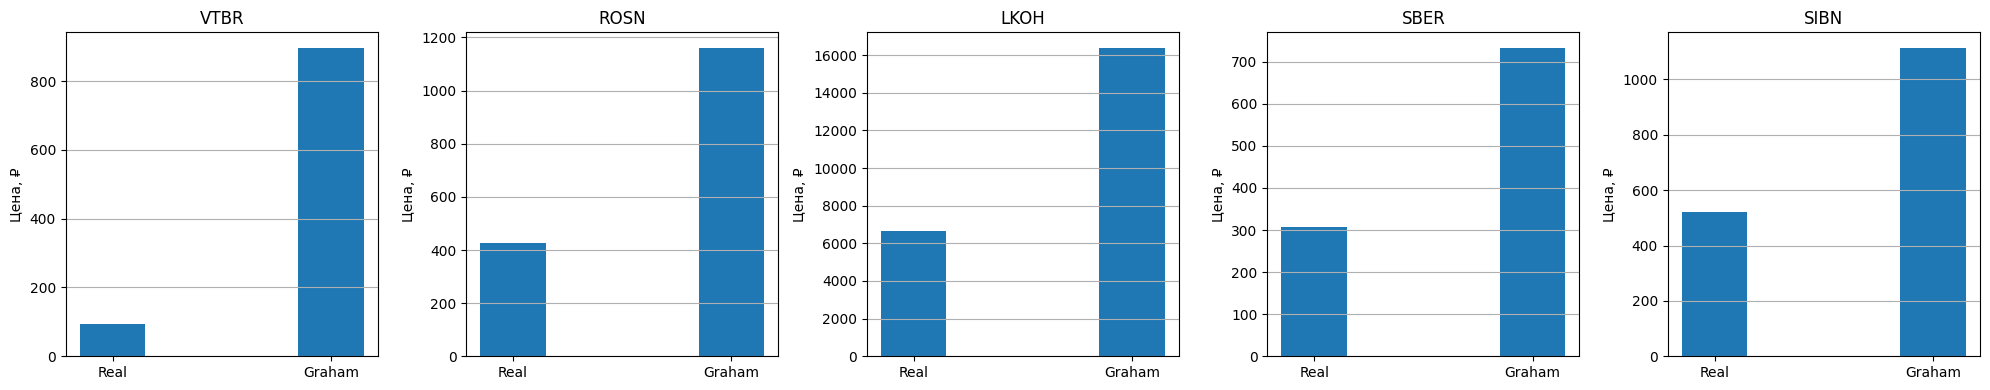

In [14]:

tickers       = valuation.index.tolist()
real_prices   = valuation['Price'].astype(float).values
graham_prices = valuation['GrahamPrice'].astype(float).values

n = len(tickers)
fig, axes = plt.subplots(1, n, figsize=(4 * n, 4), sharey=False)

for ax, ticker, rp, gp in zip(axes, tickers, real_prices, graham_prices):
    ax.bar(['Real', 'Graham'], [rp, gp], width=0.3)
    ax.set_title(ticker)
    ax.set_ylabel('Цена, ₽')
    ax.grid(axis='y')

plt.tight_layout()
plt.show()



### Мы можем заметить что оценка по Грэма даёт очень оптимистичные показатели и может сложиться ощущение, что точно надо покупать эти акции, но надо понимать, что этот показатель не охватывает все факторы.  


### Взглянем на доходность диведендов акций (какой процент стоимости акции приносят диведенды)

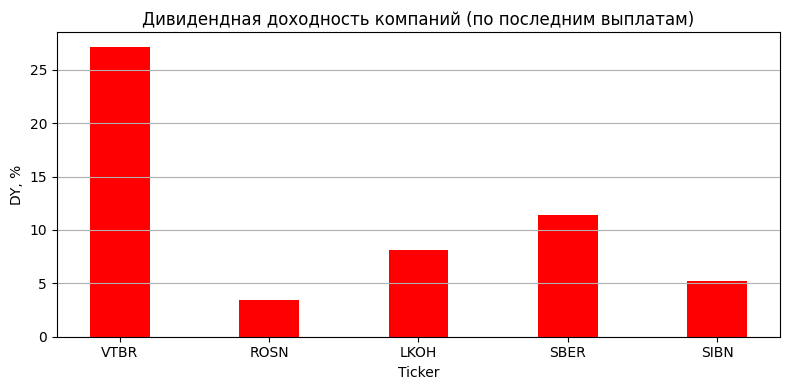

In [15]:

dy = valuation['DY'] 

# строим столбчатую диаграмму
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(dy.index, dy.to_numpy(dtype=float), width=0.4, color='red')
ax.set_title('Дивидендная доходность компаний (по последним выплатам)')
ax.set_ylabel('DY, %')
ax.set_xlabel('Ticker')
ax.grid(axis='y')
plt.tight_layout()
plt.show()


### Cамые доходные диведенды у ВТБ. Но важно также обратить внимание как часто компании платят диведенды, посмотрим на выплаты с 2020 года

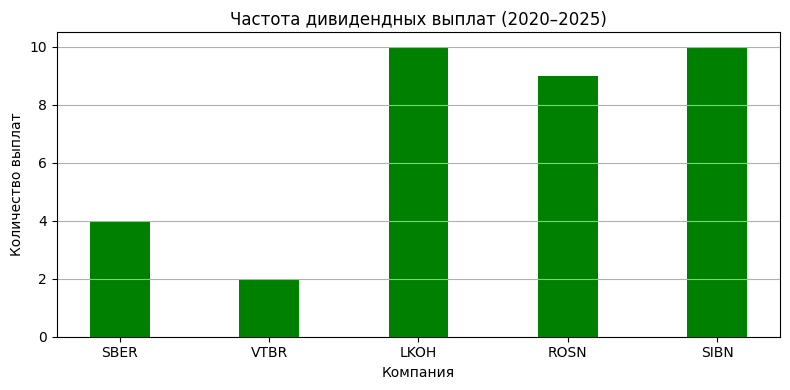

In [23]:


# Данные по выплатам дивидендов с 2020 года
dividends = {
    'SBER': [18.7, 18.7, 25, 33.3],
    'VTBR': [0.000773453, 0.0014],
    'LKOH': [350, 46, 213, 340, 537, 256, 438, 447, 498, 514],
    'ROSN': [18.07, 6.94, 18.03, 23.63, 20.39, 17.97, 30.77, 29.01, 36.47],
    'SIBN': [19.82, 5, 10, 40, 16, 69.78, 12.16, 82.94, 19.49, 51.96]
}

# Считаем количество выплат для каждой компании
counts = {ticker: len(payments) for ticker, payments in dividends.items()}

# Строим столбчатую диаграмму
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(list(counts.keys()), list(counts.values()), color='green', width=0.4)
ax.set_title('Частота дивидендных выплат (2020–2025)')
ax.set_xlabel('Компания')
ax.set_ylabel('Количество выплат')
ax.grid(axis='y')
plt.tight_layout()
plt.show()


### Чаще всего диведенды платили Лукойл, Роснефть и Газпром Нефть. Теперь посмотрим сколько мы бы смогли пассивно заработать на диведендах, если бы купили каждую акцию в 2020 году на 1000р

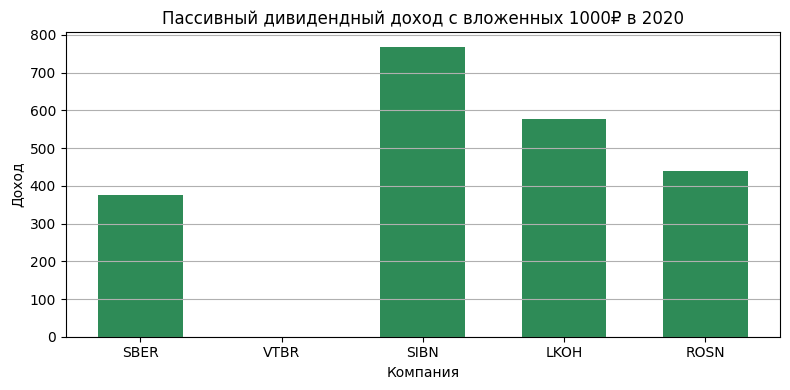

In [24]:


# 2) Цена акции на первый доступный день 2020
initial_prices = prices.iloc[0]   
initial_investment = 1000         

# 3) Считаем, сколько акций купили и сколько получили дивидендов
rows = []
for t in TICKERS:
    init_price = initial_prices[t]
    shares = initial_investment / init_price
    total_div = sum(dividends[t])
    income = shares * total_div
    
    rows.append({
        'Ticker': t,
        'InitPrice (₽)': init_price,
        'Shares': round(shares, 4),
        'TotalDiv/Share (₽)': total_div,
        'PassiveIncome (₽)': round(income, 2),
    })

df_income = pd.DataFrame(rows).set_index('Ticker')

# 4) Столбчатая диаграмма дохода
fig, ax = plt.subplots(figsize=(8,4))
ax.bar(df_income.index, df_income['PassiveIncome (₽)'], color='seagreen', width=0.6)
ax.set_title('Пассивный дивидендный доход с вложенных 1000₽ в 2020')
ax.set_ylabel('Доход')
ax.set_xlabel('Компания')
ax.grid(axis='y')
plt.tight_layout()
plt.show()

### Видим, что мы почти смогли бы пассивно удвоить вложенные 1000р купив бы акции Газпром Нефти, только на диведендах.
### Теперь давайте добавим к этому изменение стоимости акции, посмотрим сколько мы бы получили купив акции на 1000р в 2020 году и продав сегодня (Сегодняшняя цена - Цена в начале + Диведенды)

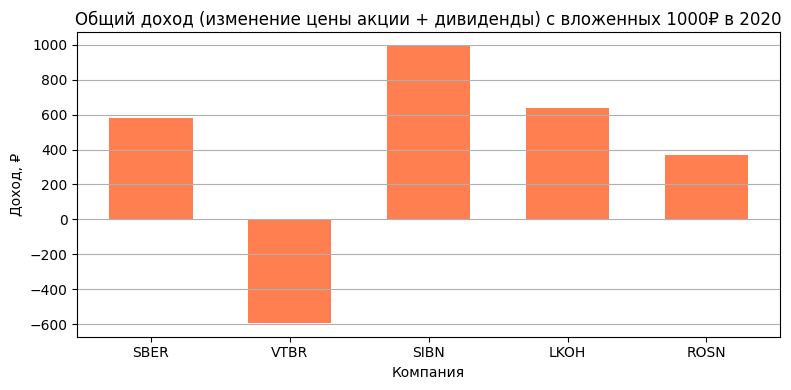

In [25]:
initial_prices = prices.iloc[0]
last_prices    = prices.iloc[-1]


# 3) Считаем по каждой акции
rows = []
for t in TICKERS:
    init_p = initial_prices[t]
    last_p = last_prices[t]
    shares = initial_investment / init_p
    total_div      = sum(dividends[t])
    capital_gain   = (last_p - init_p) * shares
    dividend_income = shares * total_div
    total_profit   = capital_gain + dividend_income
    roi_pct        = total_profit / initial_investment * 100

    rows.append({
        'Ticker': t,
        'InitPrice (₽)': round(init_p,2),
        'LastPrice (₽)': round(last_p,2),
        'Shares': round(shares,4),
        'CapitalGain (₽)': round(capital_gain,2),
        'DividendIncome (₽)': round(dividend_income,2),
        'TotalProfit (₽)': round(total_profit,2),
        'ROI (%)': round(roi_pct,2)
    })

df_perf = pd.DataFrame(rows).set_index('Ticker')

# 4) Визуализация общего дохода
fig, ax = plt.subplots(figsize=(8,4))
ax.bar(df_perf.index, df_perf['TotalProfit (₽)'], color='coral', width=0.6)
ax.set_title('Общий доход (изменение цены акции + дивиденды) с вложенных 1000₽ в 2020')
ax.set_ylabel('Доход, ₽')
ax.set_xlabel('Компания')
ax.grid(axis='y')
plt.tight_layout()
plt.show()

## Опять лидирует Газпром Нефть. Это акция выглядит наиболее перспективной для вложений